In [1]:
from pyeosim import datasets
import matplotlib.pyplot as plt
import xarray
import numpy as np
from Py6S import *
# # Create a SixS object called s (used as the standard name by convention)
# s = SixS()
# s.ground_reflectance = GroundReflectance.HomogeneousLambertian(1)
# geom = Geometry.User()
# geom.from_time_and_location(lat=52.04, lon=0.76, datetimestring='2020/06/22T12:00',
#                             view_z=0, view_a=0)
# s.geometry = geom

# s.altitudes.set_sensor_satellite_level()

# # Run the 6S simulation defined by this SixS object across the
# # whole VNIR range
# wavelengths1, results1 = SixSHelpers.Wavelengths.run_wavelengths(s, np.arange(400,900,2)/1000,
#                                                                output_name='pixel_radiance')
# # Plot these results, with the y axis label set to "Pixel Radiance"
# SixSHelpers.Wavelengths.plot_wavelengths(wavelengths1, results1, "Pixel Radiance")
# ref_100 = xarray.DataArray(results1, [('wavelength', wavelengths1*1000)]).interp(
#     wavelength = np.arange(400,900,1)
# ).interpolate_na('wavelength')

# rho = np.arange(0,1,.001)
# output = np.empty(shape=(len(rho), 500))

# for i, _rho in enumerate(rho):
#     _res = ref_100* _rho
#     output[i,:] = _res

# LUT = xarray.DataArray(output,[('rho', rho),('wavelength', np.arange(400,900,1))])
# LUTd = LUT.to_dataset(name='pixel_radiance')
# LUTd.attrs['6S_output_params'] = str(s.outputs.values)
# LUTd.to_netcdf('test2.LUT')

In [2]:
def plot_rgb(open_datafile, return_array=False, **imshow_kwargs):
    """
    Get values and apply dtype conversion and histogram equalization

    Parameters
    ----------
    open_datafile : xarray.DataSet or xarray.DataArray
        raster dataset or DataArray
    """
    ar = open_datafile.transpose('y', 'x', 'band').copy()
    ar.values = _image_histogram_equalization(ar.values)
    if return_array:
        return ar
    ar.plot.imshow(**imshow_kwargs)


def _image_histogram_equalization(image, number_bins=256, cdf=None, bins=None):
    # get image histogram
    if cdf is None:
        image_histogram, bins = np.histogram(image.flatten(), number_bins)
        cdf = image_histogram.cumsum()  # cumulative distribution function
        cdf = 255 * cdf / cdf[-1]  # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
    return image_equalized.reshape(image.shape).astype('uint8')

In [3]:
from pyeosim.sensor import LinearCCD
from pyeosim.atmospheric import SixSAtmosphere

In [4]:
atmos = SixSAtmosphere(LUT_path='test_6s.LUT')
# ccd = LinearCCD()
# ccd.get_params()

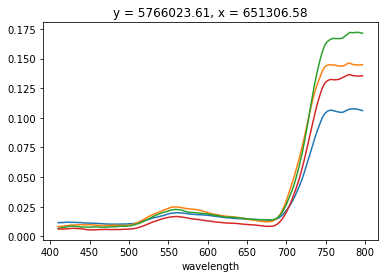

In [5]:
fpath = '../georis/georis/TEST_dataset/TEST collect/TEST-1-20200621/L3_rect/TEST-1-20200622-1_06_VNIR_1800_SN00826_quac_specPol_rectGe.img'
im = xarray.open_rasterio(fpath)
im = im.assign_coords(wavelength=('band',[float(x[:6]) for x in im.descriptions]))
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,800))/10000
im_ref.isel(x=0,y=0).plot()
im_ref.isel(x=0,y=1).plot()
im_ref.isel(x=1,y=0).plot()
im_ref.isel(x=1,y=1).plot()

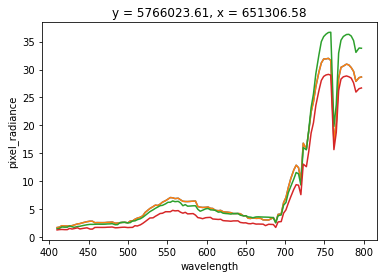

In [6]:
TOA = atmos.transform(im_ref)
TOA.isel(x=0,y=1).plot()
TOA.isel(x=0,y=1).plot()
TOA.isel(x=1,y=0).plot()
TOA.isel(x=1,y=1).plot()

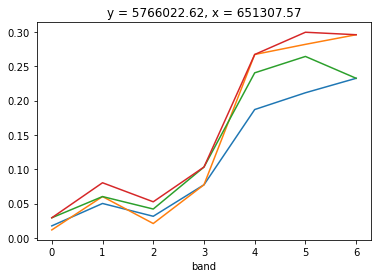

In [7]:
ccd = LinearCCD(integration_time=.2,
                 sense_node_gain=5,
                 dark_noise=50,
                 adc_gain=2000,
                 adc_vref=5,
                 full_well=33000,
                 store_steps=True,
                 ccd_vref=5,
                 Q_e=.6,
                 psf_fwhm=2.2,
                 ground_sample_distance=1)

ref = atmos.transform(xarray.ones_like(TOA))
out = ccd.transform(TOA)
out_r = out/ccd.transform(ref).mean(['x','y'])
out_r.isel(x=0,y=0).plot()
out_r.isel(x=0,y=1).plot()
out_r.isel(x=1,y=0).plot()
out_r.isel(x=1,y=1).plot()

In [8]:
rgb_orig = im.isel(wavelength=[70,40,20]).swap_dims({'wavelength':'band'})
bgr = out.isel(band=[2,1,0])
nir = out.isel(band=[6,1,0])
ndvi = ((out.isel(band=6) - out.isel(band=2))/(out.isel(band=6) + out.isel(band=2)))

Text(0.5, 1.0, 'NDVI')

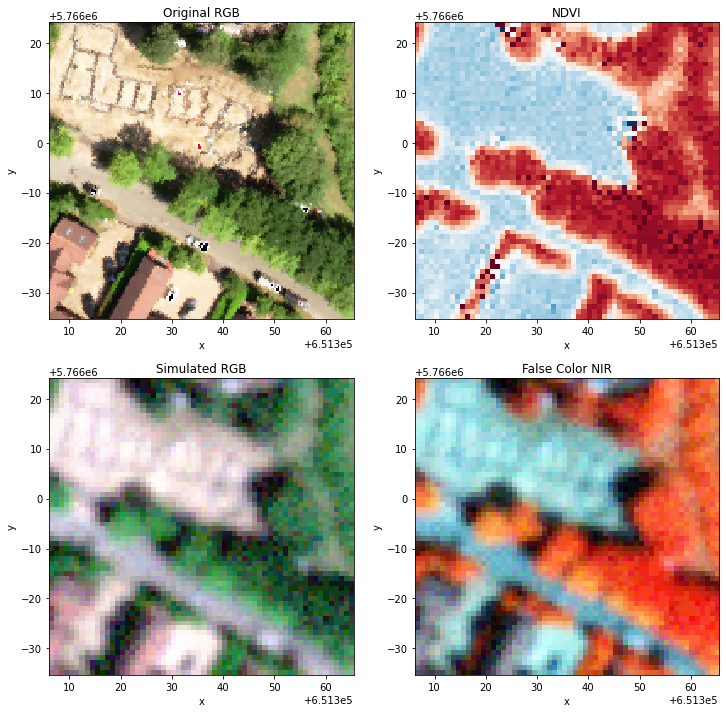

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

plot_rgb(rgb_orig,ax=ax[0][0])
ax[0][0].set_title('Original RGB')

plot_rgb(bgr,ax=ax[1][0])
ax[1][0].set_title('Simulated RGB')

plot_rgb(nir,ax=ax[1][1])
ax[1][1].set_title('False Color NIR')

ndvi.plot(ax=ax[0][1], add_colorbar=False, robust=True)
ax[0][1].set_title('NDVI')